In [3]:
import pandas as pd

In [329]:
year = 2022
country = "France"
geography = "department_id"

In [330]:
output = []
for method in ["std", "std_rank", "skew", "kurtosis", "er"]: #, "divisiveness"
    try:
        path = f"data_output/{country}/{year}_divisiveness_{geography}_{method}.csv.gz"
        tmp = pd.read_csv(path, compression="gzip")
        tmp["method"] = method
        output.append(tmp)
    except:
        pass
    
df = pd.concat(output, ignore_index=True)

In [331]:
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_fround = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")
df_fround = pd.merge(df_fround, df_location[["polling_id", geography]], on="polling_id")
df_fround = df_fround.groupby([geography, "candidate"]).agg({"value": "sum"})
df_fround["value"] = df_fround.groupby(level=[0]).apply(lambda x: x/x.sum())
df_fround = df_fround.reset_index()
df_fround["method"] = "% First Round"
df_fround.head()

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,department_id,candidate,value,method
0,01,Anne HIDALGO,0.016948,% First Round
1,01,Emmanuel MACRON,0.276875,% First Round
2,01,Fabien ROUSSEL,0.017831,% First Round
3,01,Jean LASSALLE,0.032658,% First Round
4,01,Jean-Luc MÉLENCHON,0.173657,% First Round


In [332]:
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gz", compression="gzip")
df_runoff = pd.merge(df_runoff, df_location[["polling_id", geography]], on="polling_id")
df_runoff = df_runoff.groupby([geography, "candidate"]).agg({"value": "sum"})
df_runoff["value"] = df_runoff.groupby(level=[0]).apply(lambda x: x/x.sum())
df_runoff = df_runoff.reset_index()
df_runoff["method"] = "% Runoff"
df_runoff.head()

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,department_id,candidate,value,method
0,01,Emmanuel MACRON,0.549941,% Runoff
1,01,Marine LE PEN,0.450059,% Runoff
2,02,Emmanuel MACRON,0.400897,% Runoff
3,02,Marine LE PEN,0.599103,% Runoff
4,03,Emmanuel MACRON,0.523544,% Runoff


In [333]:
candidate_a, candidate_b = df_runoff.candidate.unique()

In [334]:
dv = df_runoff.pivot(index=geography, columns="candidate", values="value").reset_index()
dv["method"] = "Dv. Runoff"
dv["value"] = 1 - np.abs(dv[candidate_a] - dv[candidate_b])
# dv[[geography, "method", "value"]]

In [335]:
# df = pd.concat([df, df_fround])
df["method"] = df["method"].replace({
    "er": "Esteban-Ray",
    "skew": "Skewness",
    "kurtosis": "Kurtosis",
    "divisiveness": "Divisiveness",
    "std": "Standard Deviation",
    "std_rank": "Std. Deviation (Rank)"
})

In [336]:
aa = df.groupby([geography, "method"]).agg({"value": "mean"}).reset_index()
aa["value"] = np.sqrt(aa["value"])

dd = pd.concat([
    aa,
    dv[[geography, "method", "value"]],
])

dd = dd[~dd[geography].str.contains("Z")]
dd = dd[~dd[geography].isin(["ANTARTICA CHILENA", "ISLA DE PASCUA", "DEL TAMARUGAL"])]

C:\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [337]:
# dd[dd["method"] == "Kurtosis"].sort_values("value").dropna()

In [338]:
data

method,Dv. Runoff,Esteban-Ray,Kurtosis,Skewness,Standard Deviation,Std. Deviation (Rank)
department_id,,,,,,
01,0.900117,2.660396,1.685582,0.966693,0.178985,0.946399
02,0.801794,2.604940,1.436085,0.930577,0.180339,0.997838
03,0.952911,2.725010,1.388415,0.915479,0.180614,1.042692
04,0.971095,2.901832,1.519122,0.932808,0.180526,1.045228
05,0.898681,3.006194,0.923365,0.778169,0.182109,1.017147
...,...,...,...,...,...,...
91,0.691463,2.815703,1.806212,0.998678,0.200943,0.975953
92,0.392205,2.896348,1.516538,0.888905,0.211606,1.006908
93,0.525570,2.826291,0.531456,0.793186,0.194133,0.934296


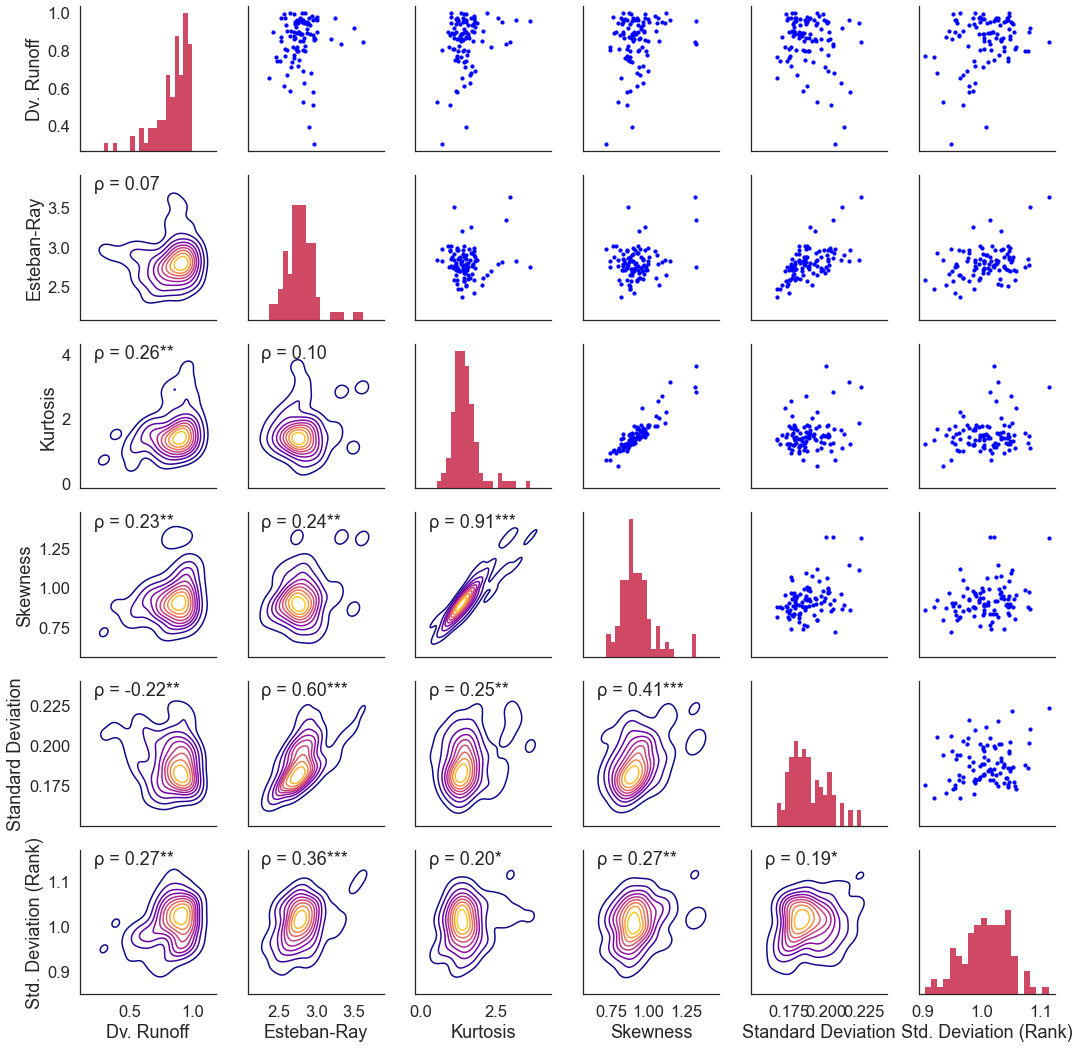

In [339]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, style="white")

data = df[df["candidate"] == "Marine LE PEN"].pivot_table(index=[geography, "candidate"], columns="method", values="value").dropna()

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    note = ""
    if _ < 0.001:
        note = "***"
    elif _ < 0.05:
        note = "**"
    elif _ < 0.1:
        note = "*"

    ax.annotate("ρ = {:.2f}{}".format(r, note),
                xy=(.1, .9), xycoords=ax.transAxes)

data = dd.pivot(index=[geography], columns="method", values="value").dropna()
g = sns.PairGrid(data, palette=["red"])
g.map_upper(plt.scatter, color="blue", s=10)
g.map_diag(sns.histplot, kde=False, lw=0, bins=20, color="#BF0A30")
g.map_lower(sns.kdeplot, cmap="plasma")
g.map_lower(corrfunc)

In [ ]:
cands = df_fround.candidate.unique()
df_fround.pivot(index=geography, columns="candidate", values="value")

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# intialize pca and logistic regression model
pca = PCA(n_components=5)
# lr = LogisticRegression(multi_class='auto', solver='liblinear')
X = df_fround.pivot(index=geography, columns="candidate", values="value")
# fit and transform data
pca.fit(X)

PCA(n_components=5)